In [36]:
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use("default")

import matplotlib.pyplot as plt
import torch
from torch import optim
import numpy as np
from torch_geometric.data import HeteroData
from torch_scatter import scatter_mean
from modeling.sampling import train_val_test_split_user_stratified

from modeling.losses import BPR_loss
from modeling.metrics import calculate_metrics
from modeling.sampling import prepare_training_data, sample_minibatch
from modeling.layers.bipartite_gcn import BipartiteGCN
from modeling.models.TB_simple import TBBaselineModel
from modeling.utils import get_coauthor_edges

torch.manual_seed(1)

# Load data
data: HeteroData = torch.load("data/hetero_data_filtered_3_2.pt", weights_only=False)

paper_ids = data["paper"].node_id
paper_embeddings = data["paper"].x
author_ids = data["author"].node_id
author_embeddings = torch.ones((data["author"].num_nodes, paper_embeddings.shape[1]))
num_authors = data["author"].num_nodes
num_papers = data["paper"].num_nodes

edge_index = data["author", "writes", "paper"].edge_index

print(f"Number of authors: {len(author_ids)}")
print(f"Number of papers: {len(paper_ids)}")
print(f"Number of edges: {edge_index.shape[1]}")

'''
# Train/val/test split and message-passing vs supervision edges
(
    message_passing_edge_index,
    supervision_edge_index,
    val_edge_index_raw,
    test_edge_index_raw,
) = prepare_training_data(edge_index)

train_edge_index_raw = torch.cat([message_passing_edge_index, supervision_edge_index], dim=1)

message_passing_edge_index = message_passing_edge_index# + edge_index_offset.view(2, 1)
supervision_edge_index = supervision_edge_index# +.view(2, 1)
val_edge_index = val_edge_index_raw #+ edge_index_offset.view(2, 1)
test_edge_index = test_edge_index_raw# + edge_index_offset.view(2, 1)'''

'''
message_passing_edge_index, supervision_edge_index, val_edge_index, test_edge_index = train_val_test_split_user_stratified(
    edge_index,
    num_authors,
    random_seed=42)
'''

Number of authors: 20950
Number of papers: 39802
Number of edges: 185956


'\nmessage_passing_edge_index, supervision_edge_index, val_edge_index, test_edge_index = train_val_test_split_user_stratified(\n    edge_index,\n    num_authors,\n    random_seed=42)\n'

In [37]:
# list degrees for all authors on message_passing edges
author_degrees = torch.zeros(num_authors, dtype=torch.long)
for author_id in message_passing_edge_index[0]:
    author_degrees[author_id] += 1
min(author_degrees), max(author_degrees)

# How many authors have degree 0?

(author_degrees == 0).sum()

IndexError: index 87805 is out of bounds for dimension 0 with size 20950

In [38]:
len(author_degrees)

20950

In [39]:
all_author_degrees = torch.zeros(num_authors, dtype=torch.long)
for author_id in edge_index[0]:
    all_author_degrees[author_id] += 1
all_paper_degrees = torch.zeros(num_papers, dtype=torch.long)
for paper_id in edge_index[1]:
    all_paper_degrees[paper_id] += 1

/tmp/ipykernel_389857/3879796532.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


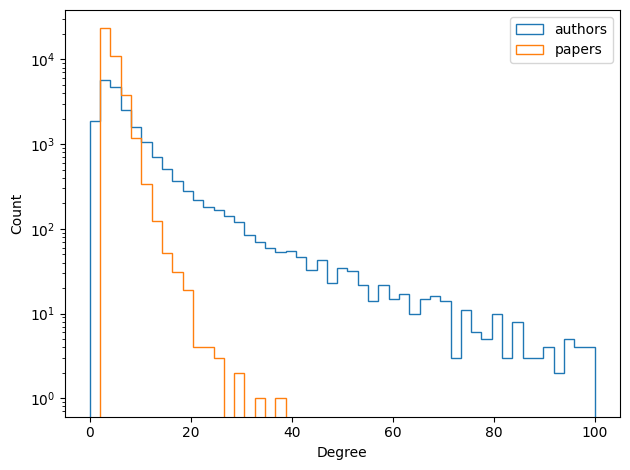

In [40]:
fig, ax = plt.subplots()
bins = np.linspace(0, 100, 50)
ax.hist(all_author_degrees.numpy(), bins=bins, label="authors", histtype="step")
ax.hist(all_paper_degrees.numpy(), bins=bins, label="papers", histtype="step")
ax.set_yscale("log")
ax.set_xlabel("Degree")
ax.set_ylabel("Count")
ax.legend()
fig.tight_layout()
fig.show()


In [29]:
(all_author_degrees==1).float().mean()

tensor(0.0263)

In [20]:
(all_paper_degrees==4).float().mean()


tensor(0.1997)

In [41]:
fig.savefig("degree_distribution.png")

In [30]:
user_links = edge_index[0]

In [31]:
# check degree of users in the edge_index
user_degrees = torch.zeros(num_authors, dtype=torch.long)
for user_id in user_links:
    user_degrees[user_id] += 1

In [35]:
# how many users have degree 0?
(user_degrees == 1).sum(), len(user_degrees)

(tensor(47140), 90941)